# Предсказание оттока клиентов телекоммуникационной компании

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

**Файл `contract_new.csv`**

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv`**

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv`**

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv`**

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

# Загрузка данных

In [ ]:
!pip install phik -q
!pip install shap -q

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    LabelEncoder)
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

import time
import warnings
import phik
from tqdm.notebook import tqdm
import missingno as msno
import shap

In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

## df_contract

In [ ]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
df_contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


1. Датасет состоит из 7043 строк и 8 столбцов;
2. Общие расходы абонента `TotalCharges` имеет неправильный тип данных;
3. Названия столбцов приведены к нестандартному виду.




## df_personal

In [ ]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
df_personal.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


1. Датасет состоит из 7043 строк и 5 столбцов;
2. Все столбцы содержат категориальные данные;
3. Названия столбцов приведены к нестандартному виду.

## df_internet

In [ ]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


1. Датасет состоит из 5517 строк и 8 столбцов;
2. Все столбцы также содержат категориальные данные;
3. Названия столбцов приведены к нестандартному виду.

## df_phone

In [ ]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


1. Датасет состоит из 6361 строк и 2 столбцов;
2. Названия столбцов приведены к нестандартному виду.

# Исследовательский анализ и предобработка данных

Сначала приведем названия столбцов и типы данных к стандарту

In [ ]:
for i in [df_contract, df_internet, df_phone, df_personal]:
    i.columns = [x.lower() for x in i.columns]

In [ ]:
df_contract = df_contract.rename(columns={'customerid': 'customer_id',
                            'begindate': 'begin_date',
                            'enddate': 'end_date',
                            'paperlessbilling': 'paperless_billing',
                            'paymentmethod': 'payment_method',
                            'monthlycharges': 'monthly_charges',
                            'totalcharges': 'total_charges'})

df_internet = df_internet.rename(columns={'customerid': 'customer_id',
                            'internetservice': 'internet_service',
                            'onlinesecurity': 'online_security',
                            'onlinebackup': 'online_backup',
                            'deviceprotection': 'device_protection',
                            'streamingtv': 'streaming_tv',
                            'streamingmovies': 'streaming_movies',
                            'techsupport': 'tech_support'})

df_personal = df_personal.rename(columns={'customerid': 'customer_id',
                            'seniorcitizen': 'senior_citizen'})

df_phone = df_phone.rename(columns={'customerid': 'customer_id',
                            'multiplelines': 'multiple_lines'})

## df_contract

In [ ]:
df_contract['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

В столбце `end_date` указаны даты окончания действия договора, а также "No", что говорит о том, что данные пользователи продолжают пользоваться услугами. Создадим целевую переменную `leave`.

In [ ]:
df_contract['leave'] = df_contract['end_date'].apply(
    lambda x: x if x == 'No' else 'Yes')

Далее. Нужно учитывать, что при создании новой переменной - разницей даты окончания и даты заключения договора - от "No" нельзя отнять дату, поэтому мы вместо "No" установим актуальную на момент сбора данных - 1 февраля 2020 года.

In [ ]:
df_contract['end_date'] = df_contract['end_date'].apply(
    lambda x: '2020-02-01' if x == 'No' else x)

Приведем столбцы `begin_date` и `end_date` в формат даты.

In [ ]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

Создадим новую переменную

In [ ]:
df_contract['period_days'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [ ]:
df_contract['period_days']

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: period_days, Length: 7043, dtype: int64

`total_charges` имеет тип данных object. Поменяем на float, в параметре errors укажем "coerce", чтобы не выдавал ошибку.

In [ ]:
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

Проверим наличие пропусков после изменения типа данных:

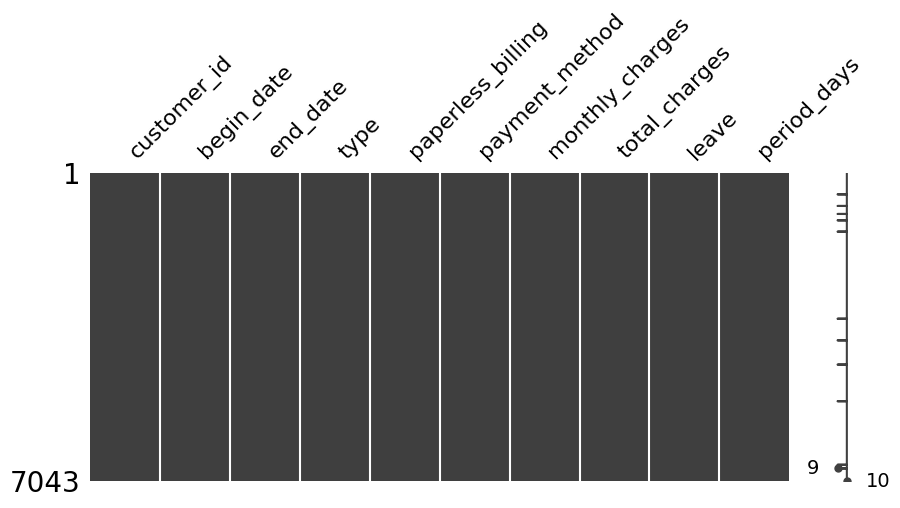

In [ ]:
msno.matrix(df_contract, figsize=(10, 4));

На графике не видно пропусков, но может быть их не так много.


In [ ]:
df_contract.isna().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
leave                 0
period_days           0
dtype: int64

Есть предположение, что пропуски в `total_charges` - это клиенты, которые начали пользоваться услугами только первый месяц. Соответственно, общие расходы у них были пропущены в `total_charges`, но хранятся в `monthly_charges`.

In [ ]:
df_contract.loc[df_contract['total_charges'].isna(), 'begin_date']

488    2020-02-01
753    2020-02-01
936    2020-02-01
1082   2020-02-01
1340   2020-02-01
3331   2020-02-01
3826   2020-02-01
4380   2020-02-01
5218   2020-02-01
6670   2020-02-01
6754   2020-02-01
Name: begin_date, dtype: datetime64[ns]

Как видно, они только подключились к услугам, а значит информация о их расходах хранится в `monthly_charges`. Перенесем ее.

In [ ]:
df_contract['total_charges'] = np.where(df_contract['total_charges'] > 0,
                                       df_contract['total_charges'],
                                       df_contract['monthly_charges'])

Условие **df_contract['total_charges'] > 0** проверяет, являются ли значения в столбце `total_charges` больше нуля. Если условие **df_contract['total_charges'] > 0** истинно, то значение в столбце `total_charges` остается без изменений, если нет, то значение в `total_charges` заменяется на значение из столбца `monthly_charges`.

Теперь определим категориальные и количественные столбцы и исследуем их.

In [ ]:
contract_cat_col = df_contract.drop('customer_id', axis=1)\
.select_dtypes(include=['object']).columns.tolist()
contract_num_col = df_contract.drop('customer_id', axis=1)\
.select_dtypes(include=['number']).columns.tolist()

In [ ]:
contract_cat_col

['type', 'paperless_billing', 'payment_method', 'leave']

In [ ]:
contract_num_col

['monthly_charges', 'total_charges', 'period_days']

In [ ]:
def categorial_plot(data, column, target):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(data=data, x=column, palette='muted', hue=target)
    ax.set_title(f'Распределение {column}')
    plt.ylabel('Количество')
    plt.xlabel('Значение')

def numeric_plot(data, column, target):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(data, x=column, hue='leave',bins=20)
    ax.set_title(f'Распределение {column}')
    plt.ylabel('Количество')
    plt.xlabel('Значение')

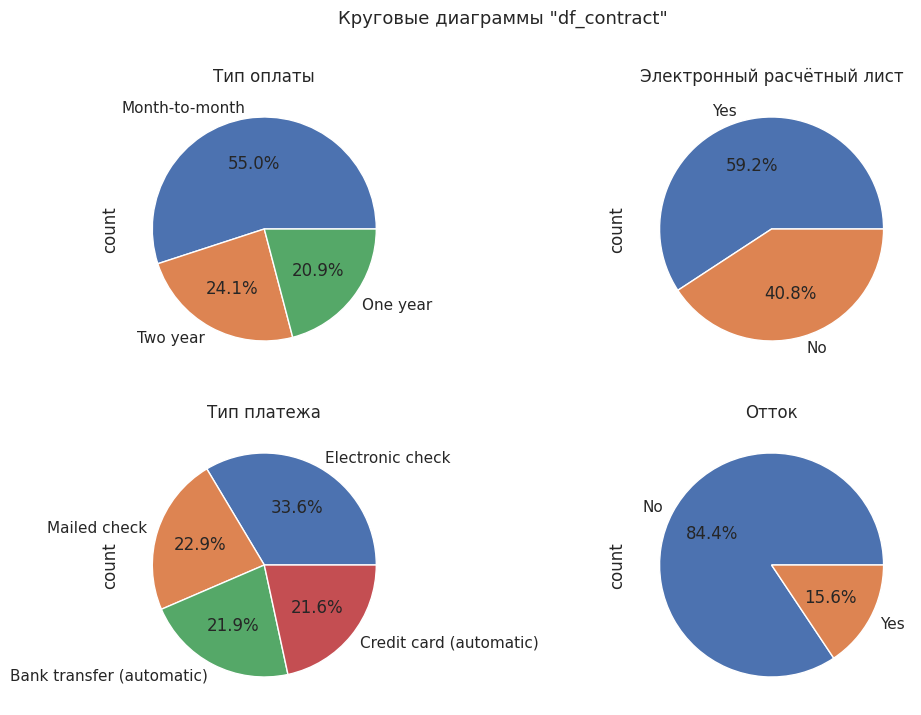

In [ ]:
plt.figure(figsize=(12, 8))
sns.set()
plt.suptitle('Круговые диаграммы "df_contract"', fontsize=13)

plt.subplot(2, 2, 1)
df_contract['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Тип оплаты')

plt.subplot(2, 2, 2)
df_contract['paperless_billing'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Электронный расчётный лист')

plt.subplot(2, 2, 3)
df_contract['payment_method'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Тип платежа')

plt.subplot(2, 2, 4)
df_contract['leave'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Отток');

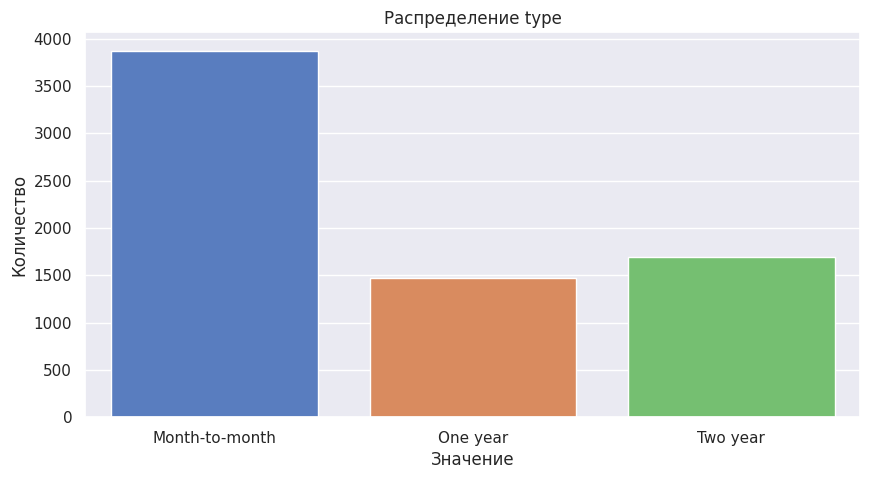

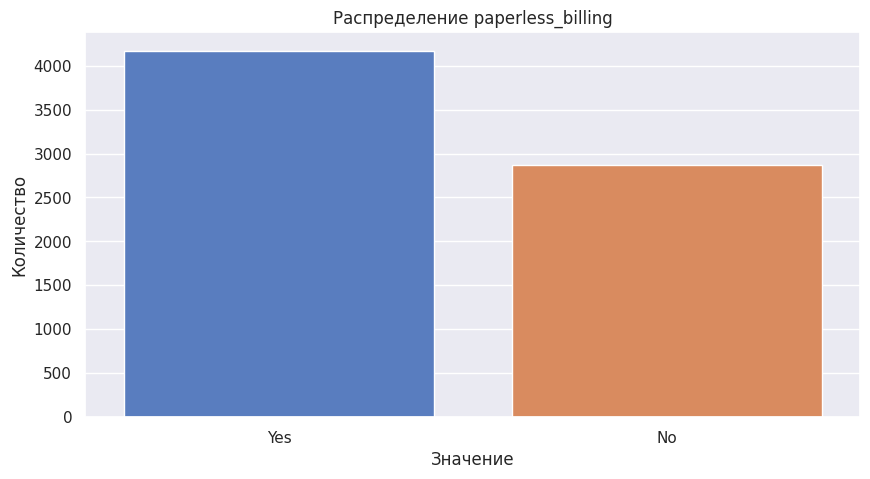

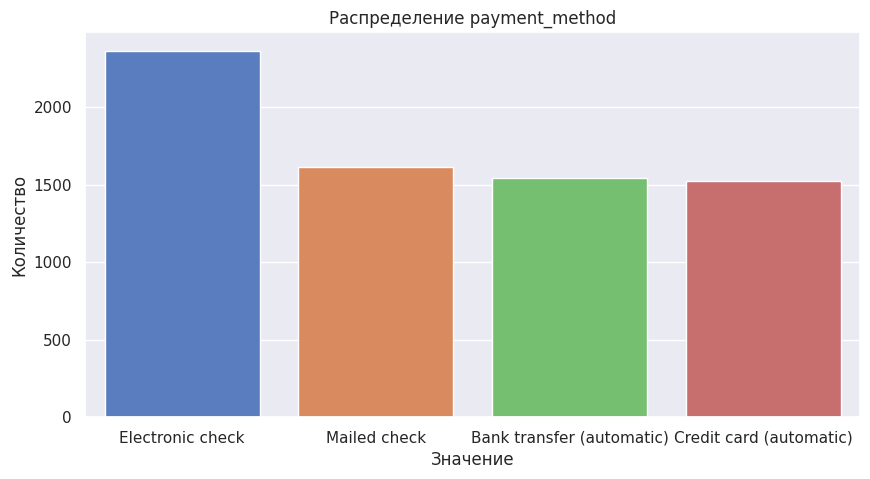

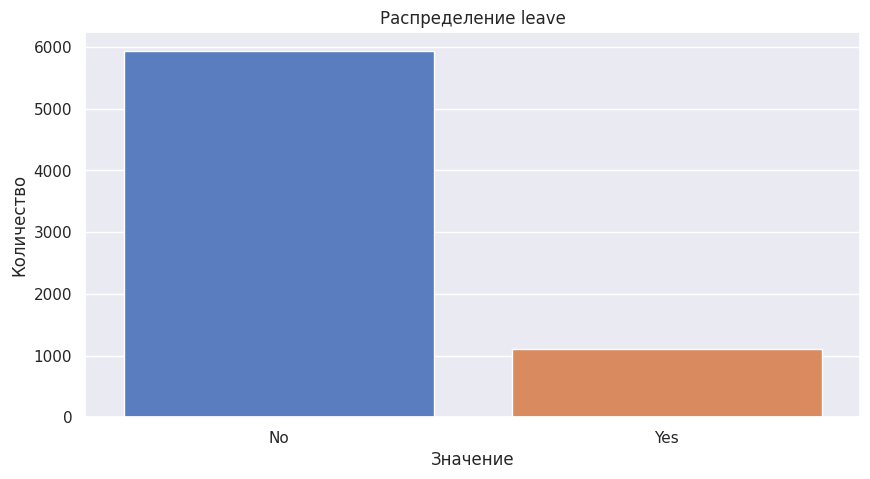

In [ ]:
[categorial_plot(df_contract, i, i) for i in contract_cat_col];

- Тип оплаты: большинство использует ежемесячные платежи (55%), на год-два оплачивают примерно равное количество;
- Электронный расчетный лист есть у 60%;
- Большинство использует Electronic check при оплате;
- Наблюдается дисбаланс классов. Большинство клиентов остаются с компанией.

Опишем количественные данные, для этого используем гистограмму.

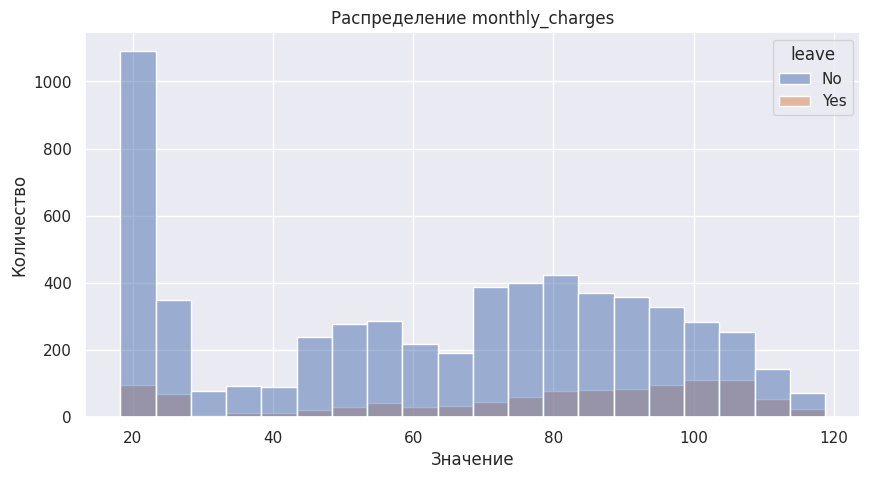

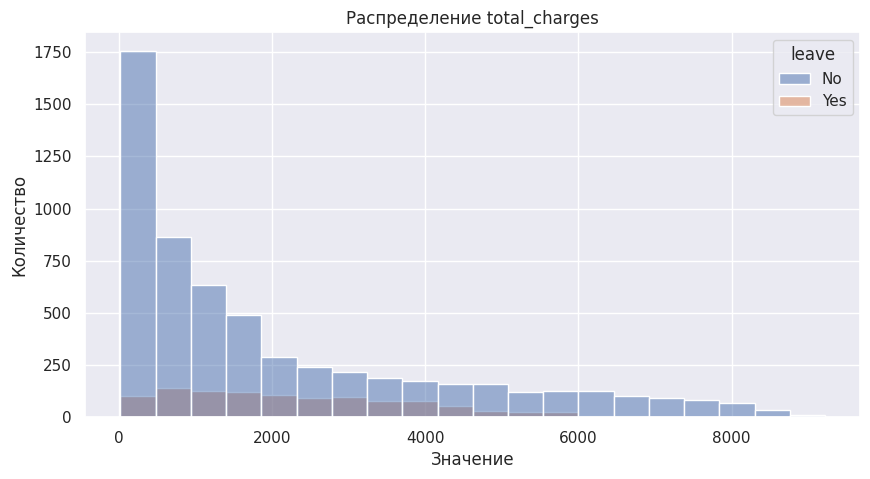

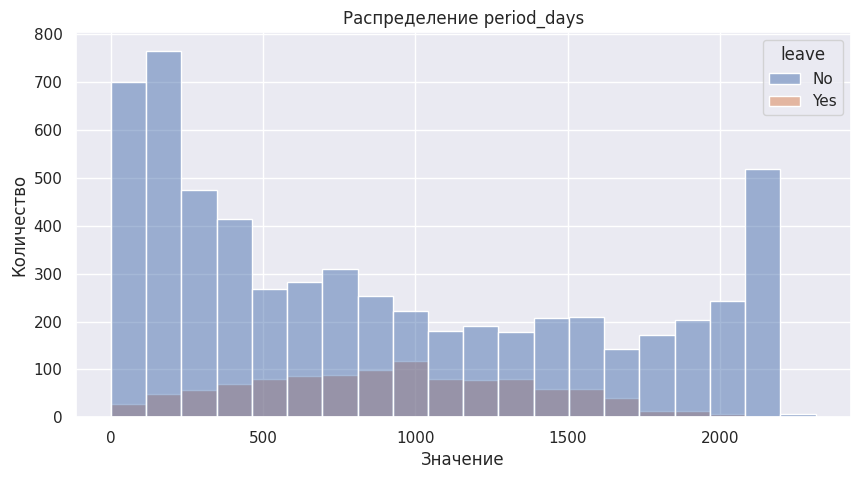

In [ ]:
[numeric_plot(df_contract, i, i) for i in contract_num_col];

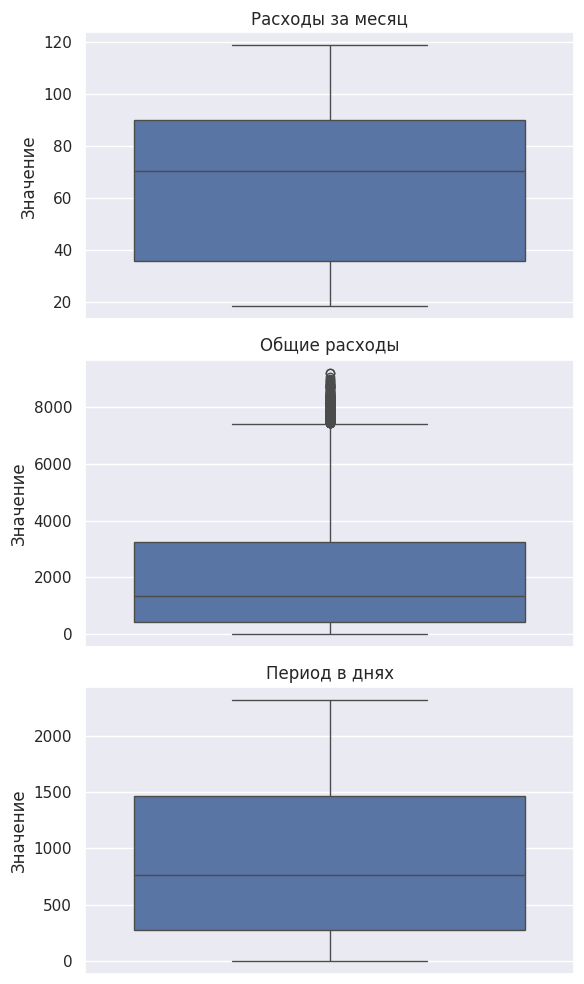

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))

sns.boxplot(data=df_contract['monthly_charges'], ax=axes[0])
axes[0].set_title('Расходы за месяц')
axes[0].set_ylabel('Значение')

sns.boxplot(data=df_contract['total_charges'], ax=axes[1])
axes[1].set_title('Общие расходы')
axes[1].set_ylabel('Значение')

sns.boxplot(data=df_contract['period_days'], ax=axes[2])
axes[2].set_title('Период в днях')
axes[2].set_ylabel('Значение')

plt.tight_layout()

plt.show()

- Месячные расходы: стоит заметить пик на 20 и на 80, медиана равна 70;
- Общие расходы: Распределение сильно скошено вправо, что означает наличие длинного хвоста с большими значениями. Большинство данных сосредоточено в нижнем диапазоне значений, медиана равна около 1600;
- Период в днях: распределение бимодальное, об этом говорят 2 пика на графике. Медиана равна 750.

## df_internet

In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


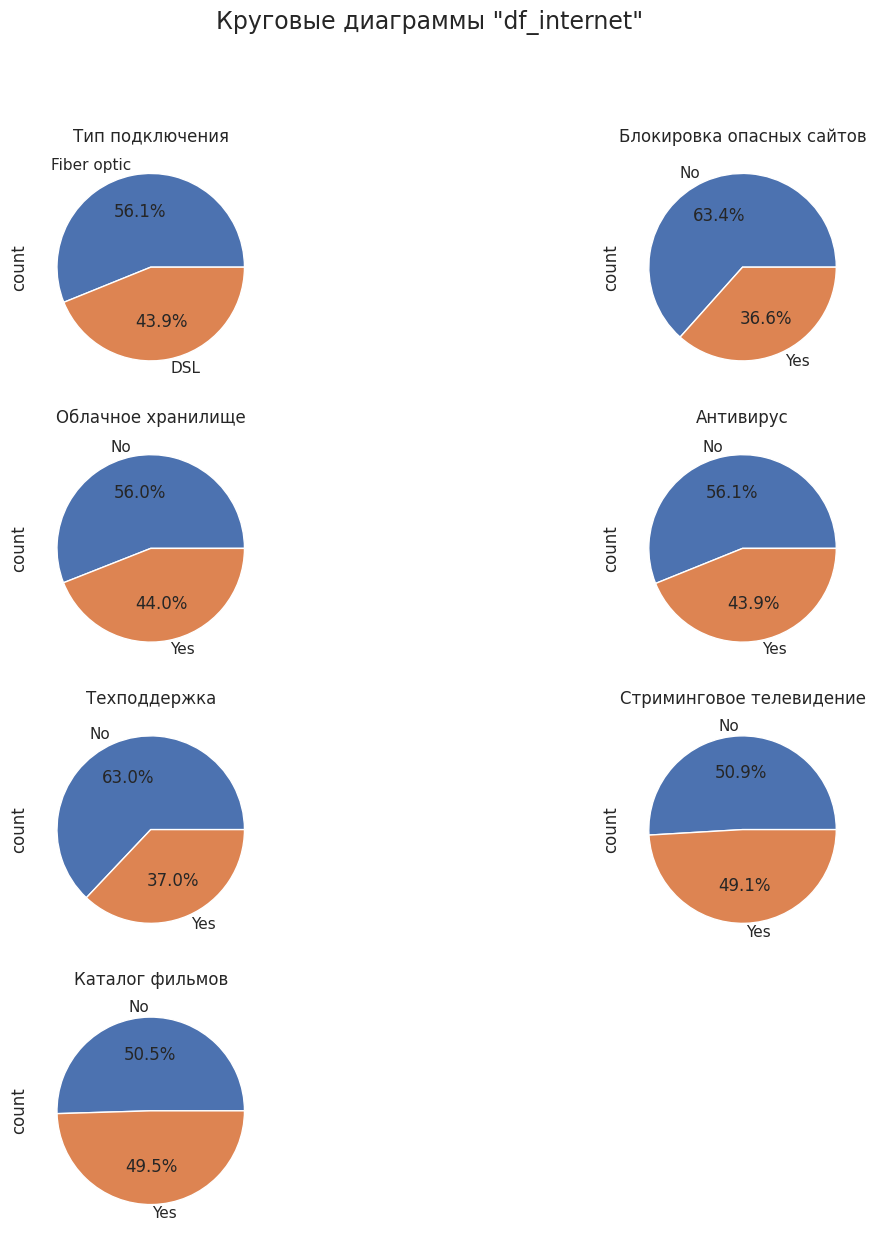

In [ ]:
plt.figure(figsize=(14, 14))
sns.set()
plt.suptitle('Круговые диаграммы "df_internet"', fontsize=17)

plt.subplot(4, 2, 1)
df_internet['internet_service'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Тип подключения')

plt.subplot(4, 2, 2)
df_internet['online_security'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Блокировка опасных сайтов')

plt.subplot(4, 2, 3)
df_internet['online_backup'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Облачное хранилище')

plt.subplot(4, 2, 4)
df_internet['device_protection'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Антивирус')

plt.subplot(4, 2, 5)
df_internet['tech_support'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Техподдержка')

plt.subplot(4, 2, 6)
df_internet['streaming_tv'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Стриминговое телевидение')

plt.subplot(4, 2, 7)
df_internet['streaming_movies'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Каталог фильмов');

- Тип подключения: наиболее популярное оптоволокно;
- Дополнительные услуги в виде блокировки опасных сайтов, облачного хранилища, антивируса и техподдержки большинство предпочитает не подключать;
- Со стриминговым TV и каталогом фильмов примерно 50 на 50.

## df_personal

In [ ]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Переведем значения в `senior_citizen` в булевый тип

In [ ]:
df_personal['senior_citizen'] = df_personal['senior_citizen'].apply(
    lambda x: 'Yes' if x == 1 else 'No')

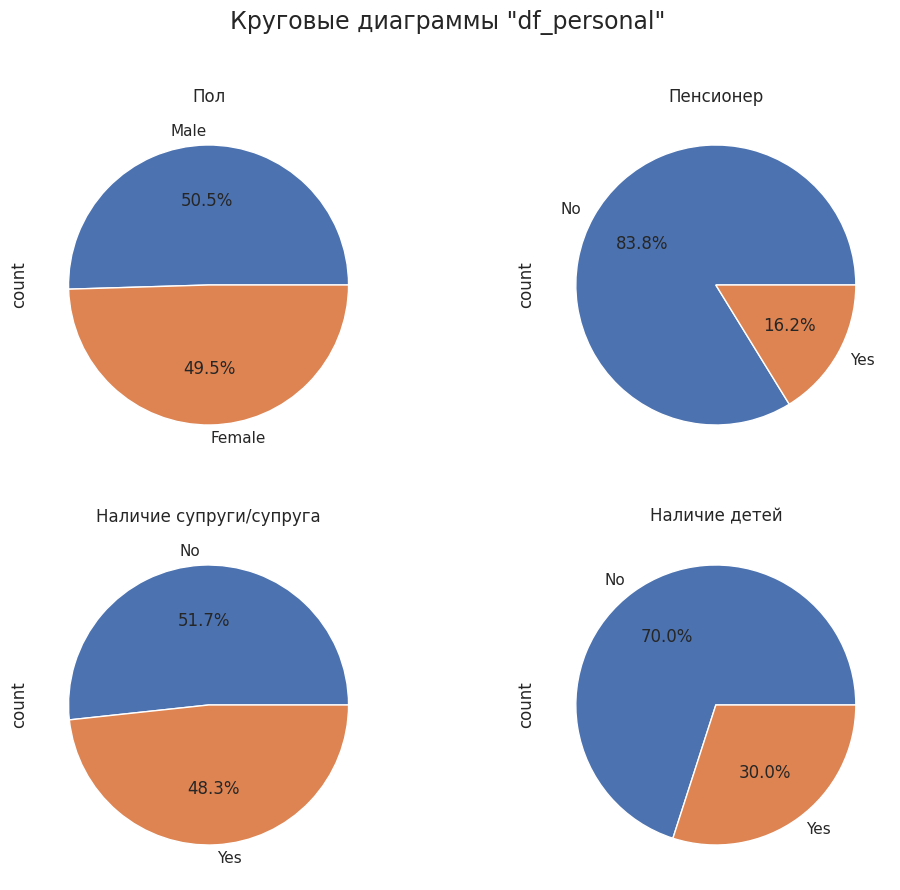

In [ ]:
plt.figure(figsize=(12, 10))
sns.set()
plt.suptitle('Круговые диаграммы "df_personal"', fontsize=17)

plt.subplot(2, 2, 1)
df_personal['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Пол')

plt.subplot(2, 2, 2)
df_personal['senior_citizen'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Пенсионер')

plt.subplot(2, 2, 3)
df_personal['partner'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Наличие супруги/супруга')

plt.subplot(2, 2, 4)
df_personal['dependents'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Наличие детей');


- Пол: женщин и мужчин примерно равное количество;
- Возраст: пенсионеров всего 16% от общего числа пользователей;
- Наличие супруги/супруга: почти в равном количестве;
- Наличие детей: у 70% клиентов нет детей.

## df_phone

In [ ]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


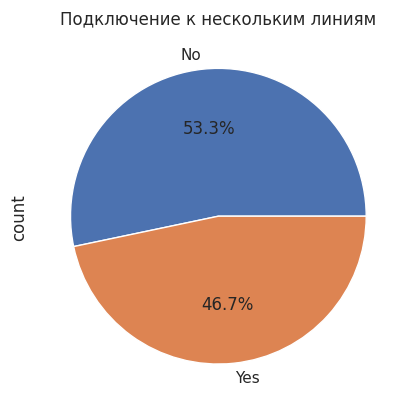

In [ ]:
df_phone['multiple_lines'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Подключение к нескольким линиям');

Различие между теми, кто подключен к нескольким линия и нет, небольшое (46.7% против 53.3%)

# Объединение данных

In [ ]:
df_full = df_contract.merge(df_personal, on='customer_id', how='outer') \
                     .merge(df_internet, on='customer_id', how='outer') \
                     .merge(df_phone, on='customer_id', how='outer')

In [ ]:
df_full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leave,period_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,No,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,No,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   leave              7043 non-null   object        
 9   period_days        7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   object        
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

Посмотрим на пропуски

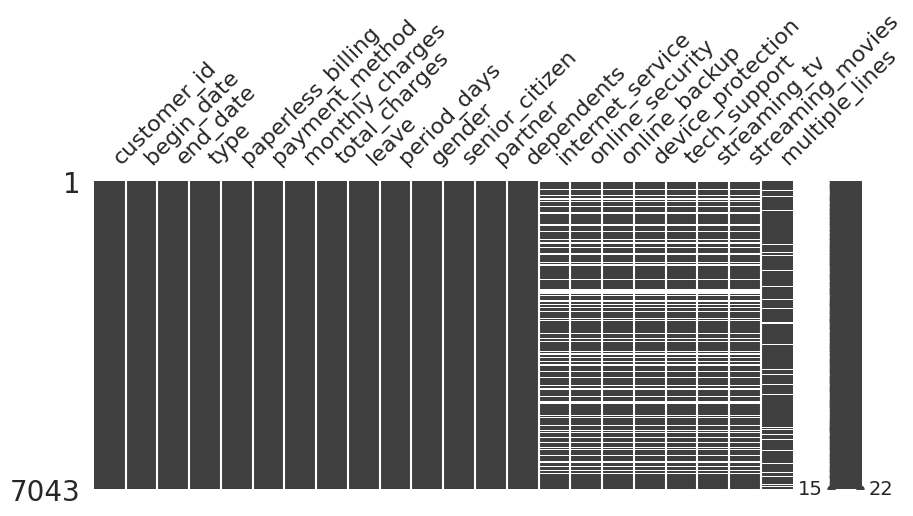

In [ ]:
msno.matrix(df_full, figsize=(10, 4));

In [ ]:
df_full.loc[df_full['internet_service'].isna(), ['internet_service',
                                                 'online_security',
                                                 'online_backup',
                                                 'device_protection',
                                                 'tech_support',
                                                 'streaming_tv',
                                                 'streaming_movies']].head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Судя по пропускам, можно предположить, что если у абонента не подключен интернет, то и других услуг у него не будет. Заполнять эти значения модой не лучшее решение, но и оставлять не хотелось бы. Заполним значением `Out of Service`, так как наиболее вероятно, что у них эти услуги не подключены, а не потому что это неизвестные значения.

In [ ]:
to_fill_na = ['internet_service', 'online_security', 'online_backup',
              'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies', 'multiple_lines']

for col in to_fill_na:
    df_full[col] = df_full[col].fillna('Out of service')

Теперь визуализируем столбцы после объединения датафреймов, но уже относительно целевой переменной

In [ ]:
categorial_col = df_full.drop('customer_id', axis=1)\
.select_dtypes(include=['object']).columns.tolist()

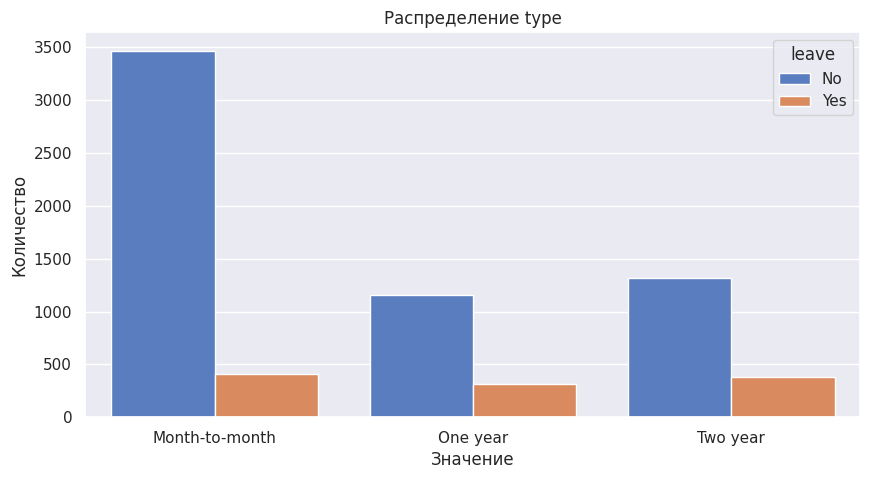

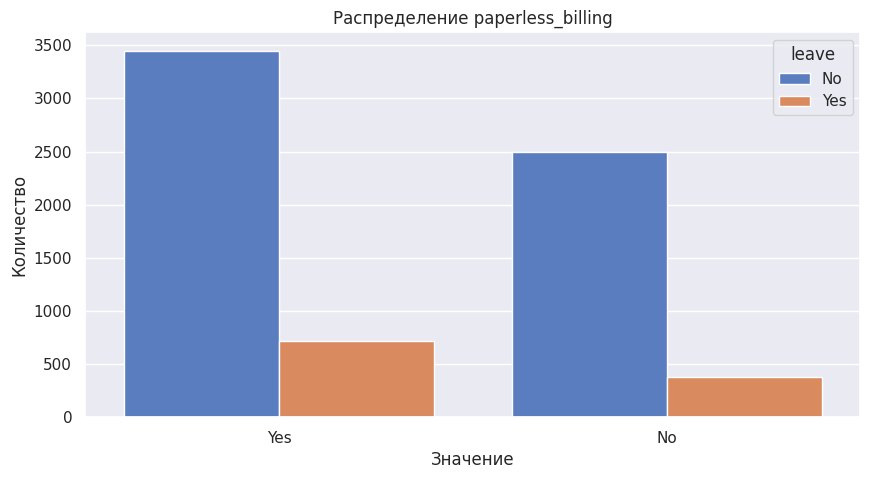

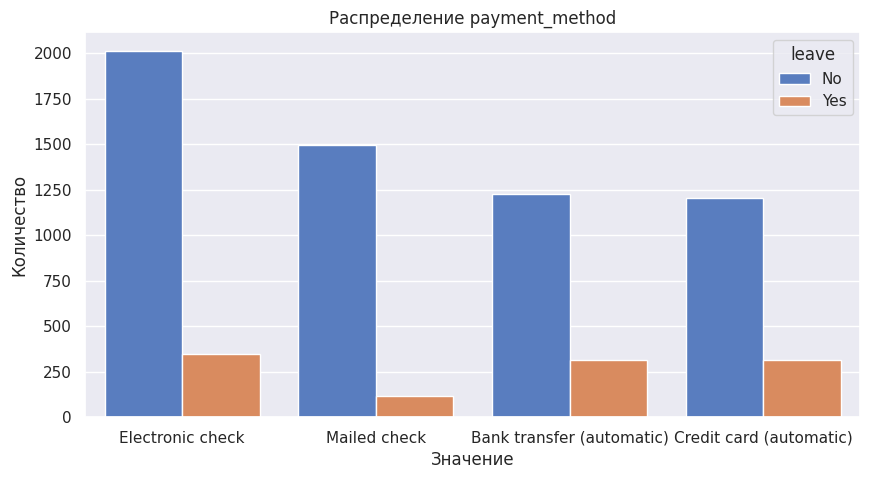

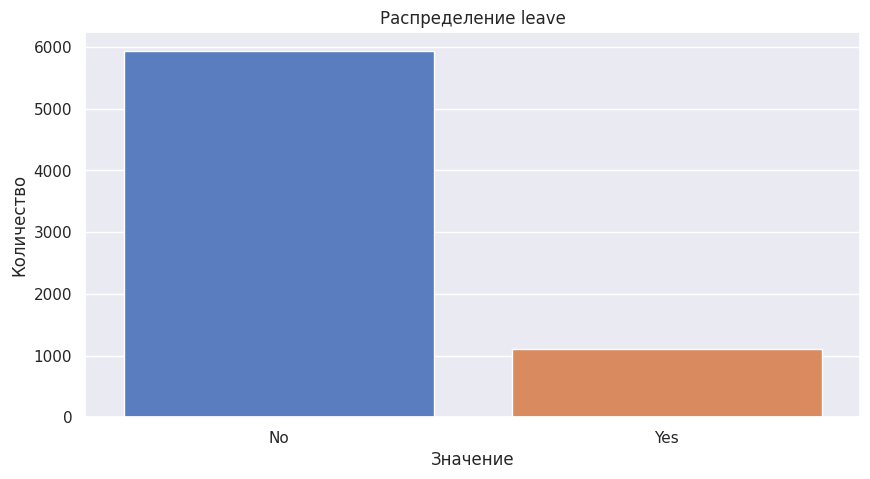

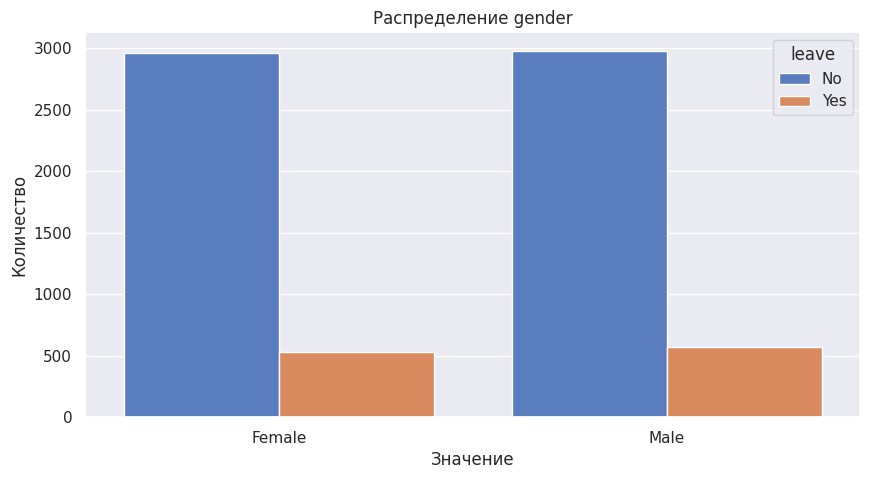

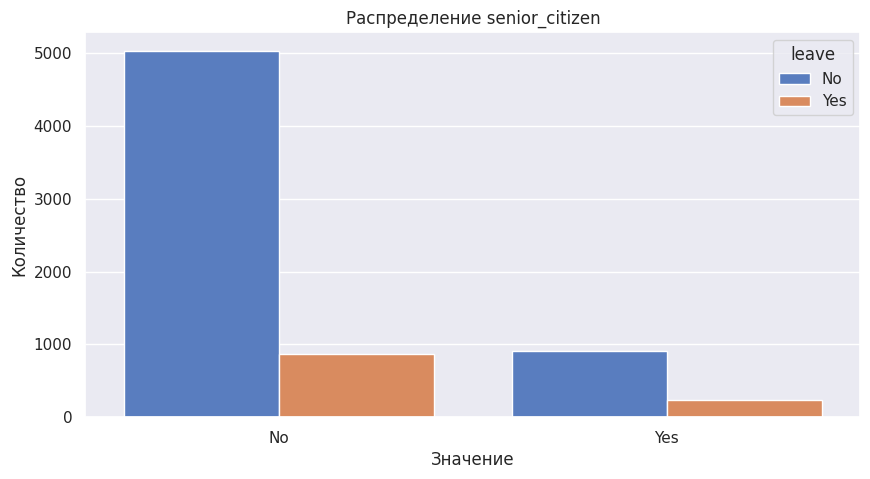

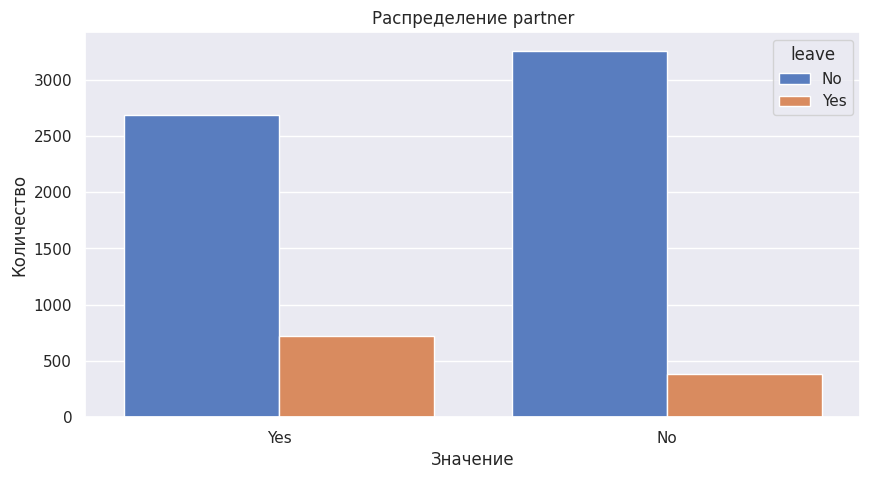

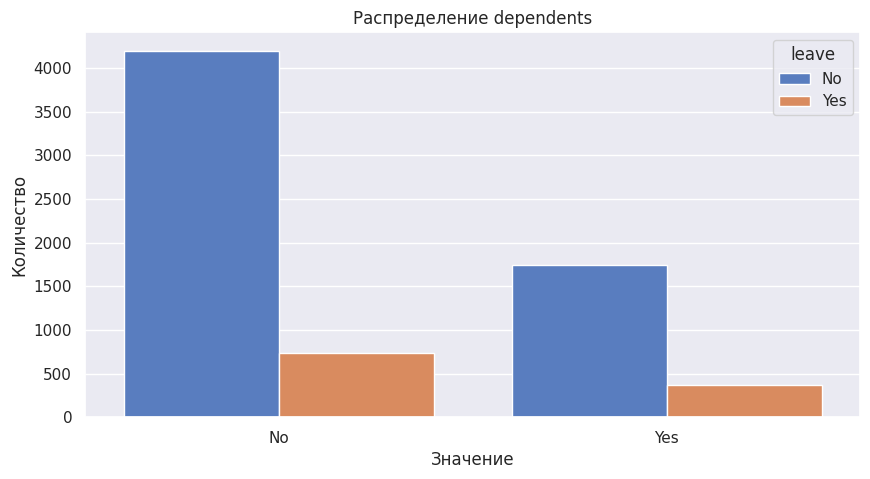

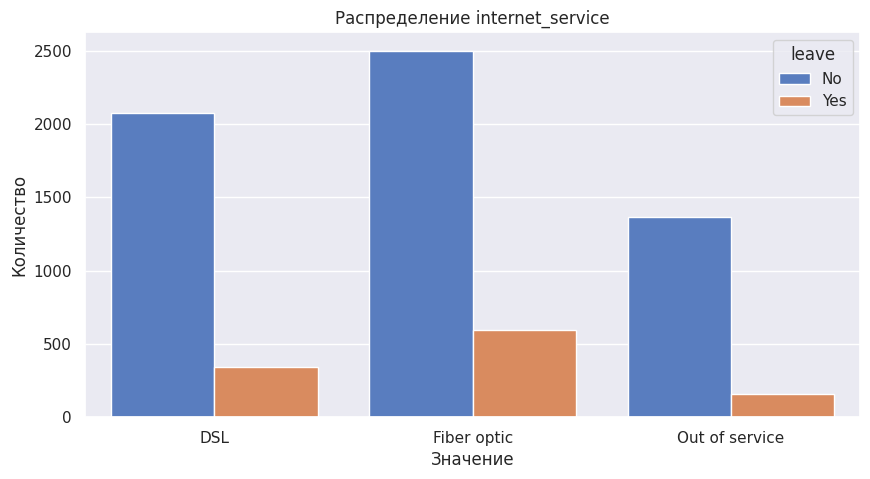

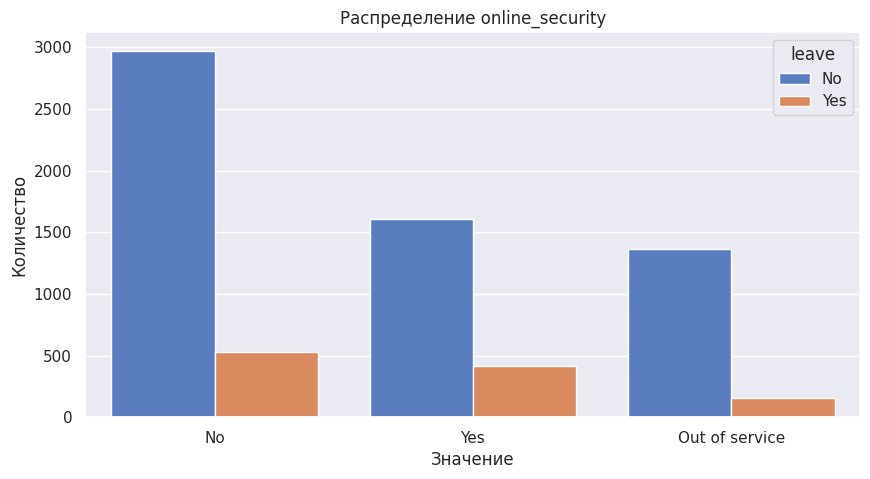

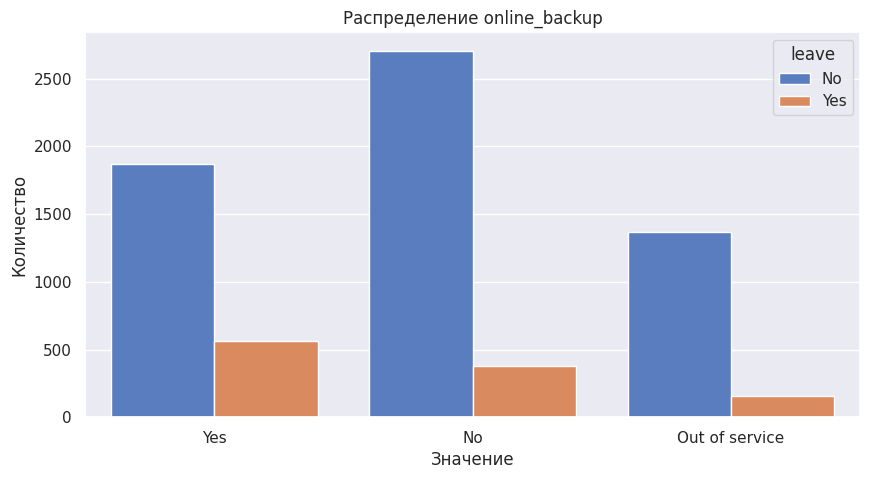

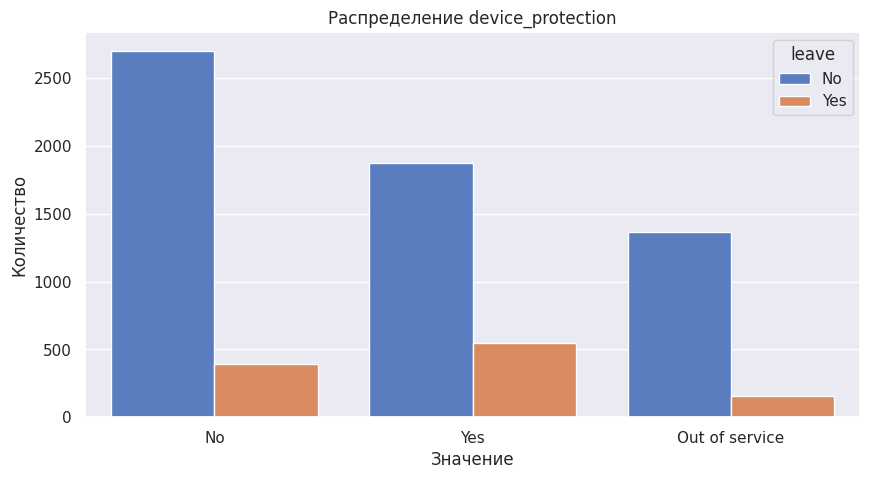

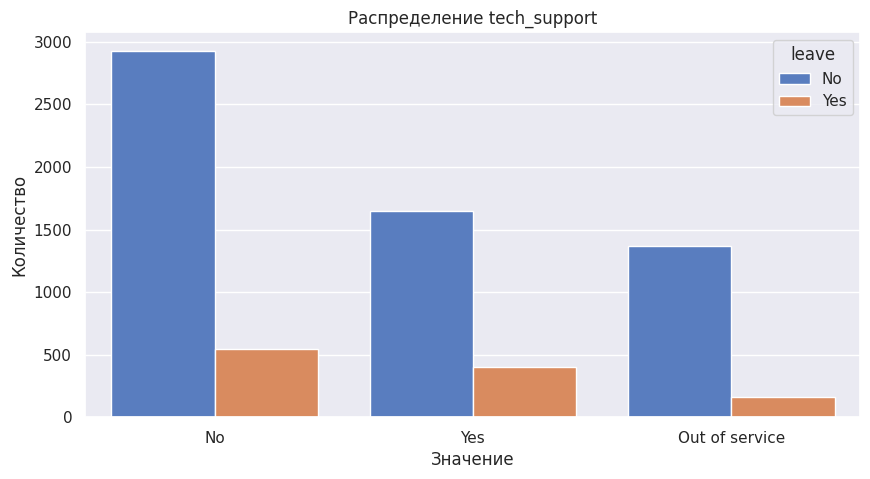

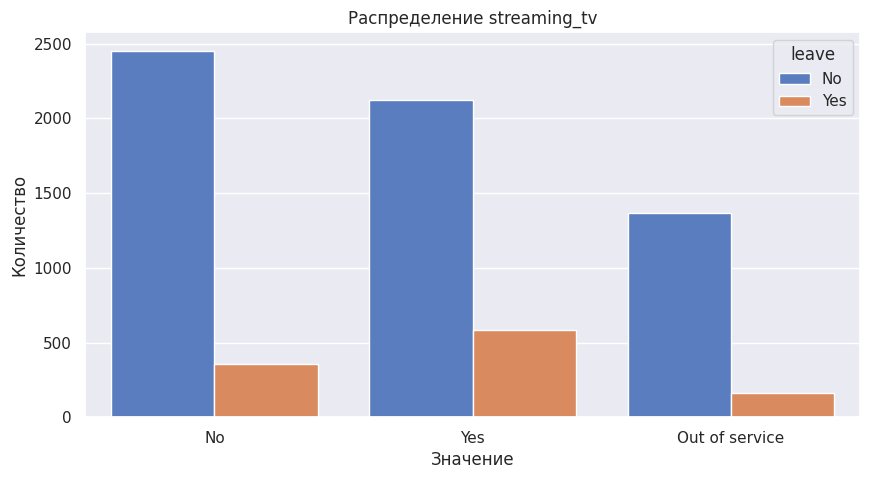

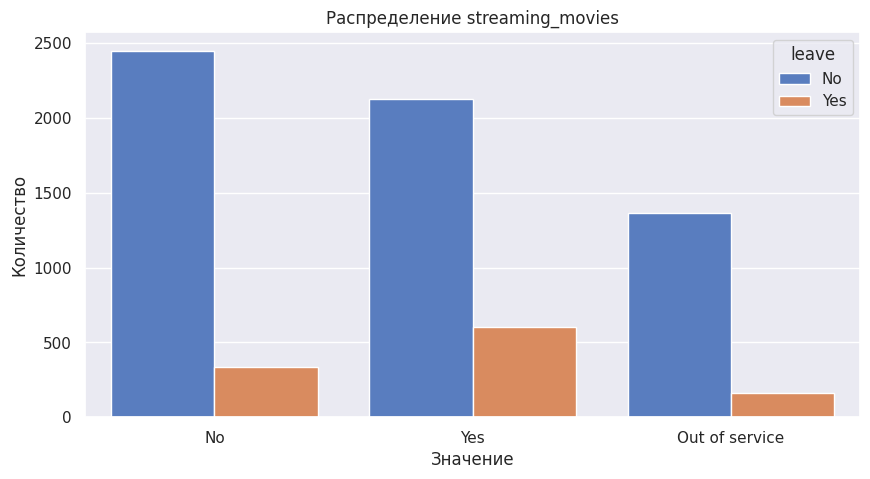

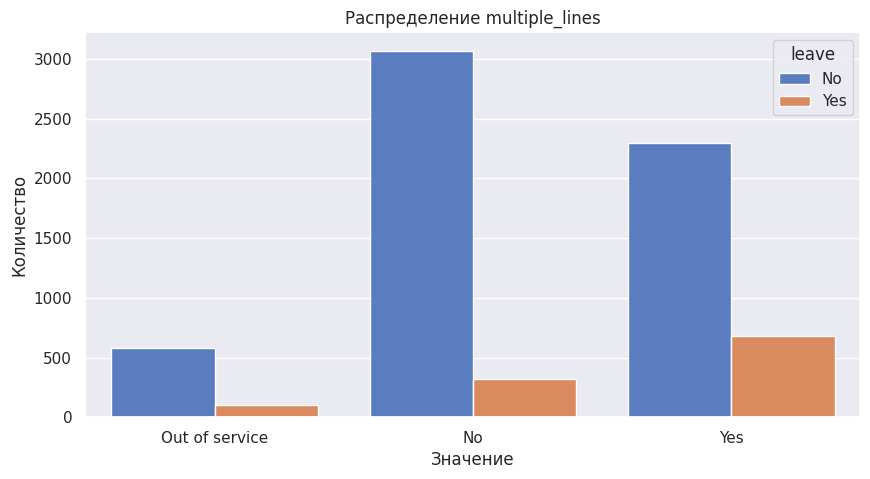

In [ ]:
[categorial_plot(df_full, i, 'leave') for i in categorial_col];

Как видно из всех графиков, ушедших клиентов не так много по сравнению с оставшимися. Это говорит о дисбалансе классов, который в далее нужно учесть. Также в признаках из датафрейма `df_internet` теперь много значений "Out of service".

## Матрица корреляций

Теперь к матрице корреляций. Предварительно, уберем столбцы с ID и датами, они не нужны.

In [ ]:
df_full = df_full.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

In [ ]:
interval_cols = ['monthly_charges', 'total_charges', 'period_days']

matrix = df_full.phik_matrix(interval_cols=interval_cols)

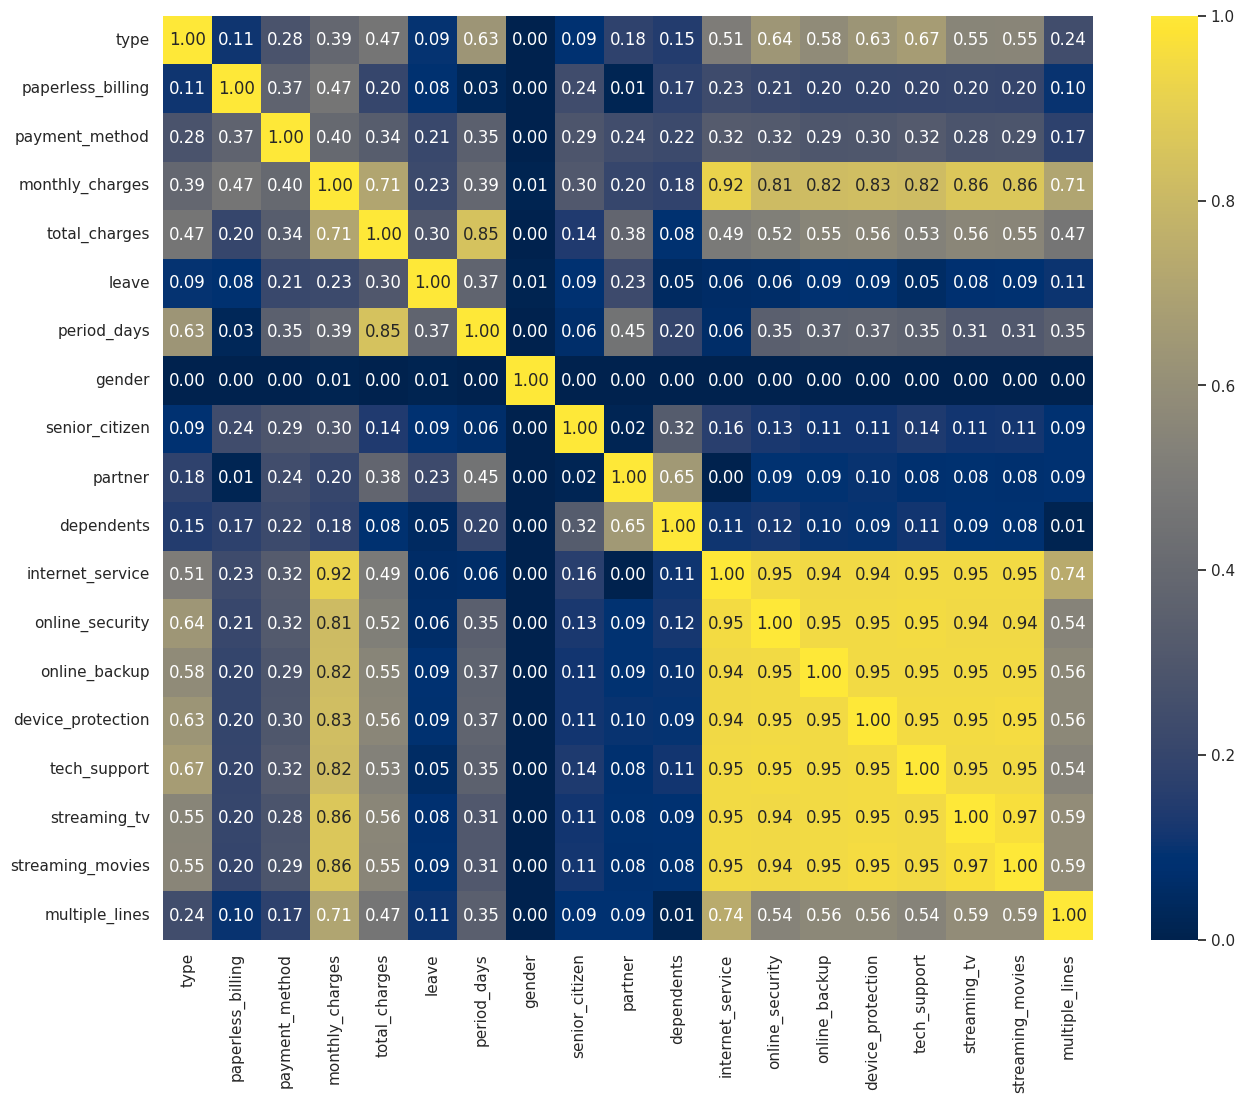

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(matrix, cmap='cividis', annot=True, fmt='.2f')
plt.show()

После заполнения пропусков, в признаках наблюдается мультиколлинеарность. Как видно, некоторые признаки почти ни с каким признаком не коррелируют, поэтому и их можно удалить.

Удалим признаки с высокой мультиколлинеарностью, оставив только `internet_service` (если у абонента не подключена эта услуга, то и в других шести нет смысла):
- `online_security`;
- `online_backup`;
- `device_protection`;
- `tech_support`;
- `streaming_tv`;
- `streaming_movies`.

Также, удалим признак, который вообще почти не коррелирует с целевым - `gender`

In [ ]:
final_data = df_full.drop(['online_security',
                           'online_backup',
                           'device_protection',
                           'tech_support',
                           'streaming_tv',
                           'streaming_movies',
                           'gender'], axis=1)

In [ ]:
final_matrix = final_data.phik_matrix(interval_cols=interval_cols)

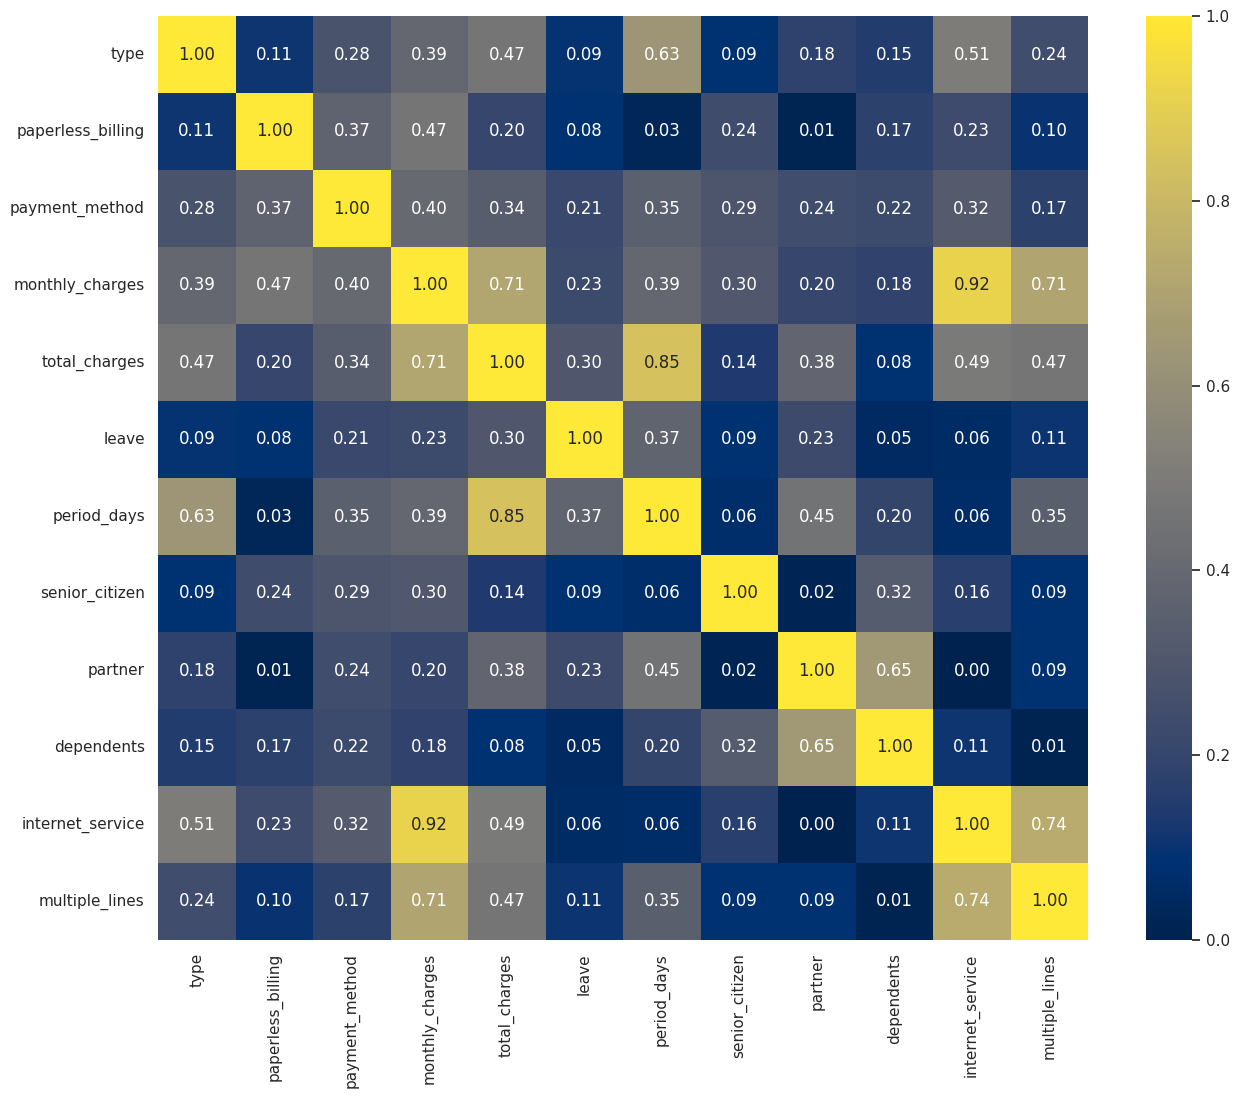

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(final_matrix, cmap='cividis', annot=True, fmt='.2f')
plt.show()

Мы удалили 7 признаков. У всех признаков наблюдается слабая корреляция с целевым, но удаление таких признаков приводит к ухудшению метрики.

# Подготовка данных

In [ ]:
RANDOM_STATE = 20052024
TEST_SIZE = 0.25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data.drop(['leave'], axis=1),
    final_data['leave'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=final_data['leave'],
    shuffle=True
)

In [ ]:
cat_columns = ['type',
               'paperless_billing',
               'payment_method',
               'senior_citizen',
               'partner',
               'dependents',
               'internet_service',
               'multiple_lines']
num_columns = ['monthly_charges',
               'total_charges',
               'period_days']

Будем использовать пайплайны, потому что так легче.

In [ ]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Out of service')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Out of service')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
)


In [ ]:
# Для линейных моделей
linear_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_columns),
     ('num', [StandardScaler()], num_columns)
    ],
    remainder='passthrough'
)
# Для деревянных моделей
tree_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_columns),
     ('num', [StandardScaler()], num_columns)
    ],
    remainder='passthrough'
)
# Для линейных моделей
pipe_onehot = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('models', LogisticRegression())
])
# Для деревянных моделей
pipe_ordinal = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('models', RandomForestClassifier())
])

In [ ]:
logreg_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='liblinear',
                                      penalty='l1',
                                      class_weight='balanced')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

In [ ]:
lgbm_grid = [
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE,
                                  class_weight='balanced',
                                  verbose=-1)],
        'models__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
        'models__n_estimators': [50, 100, 200, 300, 500, 700],
        'models__num_leaves': [20, 31, 50, 70, 100, 150],
        'models__max_depth': [-1, 10, 20, 30, 40],
        'models__min_child_samples': [10, 20, 30, 50, 100, 200],
        'models__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'models__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

In [ ]:
randomfc_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE,
                                          class_weight='balanced')],
        'models__max_depth': range(1, 10),
        'models__n_estimators': [300],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

In [ ]:
def fit_model(model, parameters, njobs):

    randomized_search = RandomizedSearchCV(
        model,
        parameters,
        cv=5,
        scoring='roc_auc',
        n_jobs=njobs,
        random_state=RANDOM_STATE
    )
    start = time.time()
    randomized_search.fit(X_train, y_train)
    finish = time.time() - start
    print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
    print ('Метрика ROC-AUC на кросс-валидации по тренировочной выборке:', randomized_search.best_score_)

    return randomized_search.best_estimator_, randomized_search.best_score_, finish

In [ ]:
lr_model, lr_score, lr_time = fit_model(pipe_onehot, logreg_grid, -1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='Out '
                                                                                            'of '
                                                                                            'service',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                   

In [ ]:
lgbm_model, lgbm_score, lgbm_time = fit_model(pipe_ordinal, lgbm_grid, 1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(fill_value='Out '
                                                                                            'of '
                                                                                            'service',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                      

In [ ]:
randomfc_model, randomfc_score,  randomfc_time = fit_model(pipe_ordinal, randomfc_grid, -1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(fill_value='Out '
                                                                                            'of '
                                                                                            'service',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                      

После обучения трех моделей, выберем ту, что показала лучшие результаты на кросс-валидационной выборке.

# Выбор лучшей модели

Построим таблицу с метриками для сравнения. Также я добавил время обучения, дабы скорее сравнить две модели RandomForestClassifier и LGBMClassifier.

In [ ]:
results = pd.DataFrame({
    'LogisticRegression': [lr_score, lr_time],
    'RandomForestClassifier': [randomfc_score, randomfc_time],
    'LGBMClassifier': [lgbm_score, lgbm_time]
}, index=['Метрика ROC-AUC', 'Время обучения'])

In [ ]:
results.T

,Метрика ROC-AUC,Время обучения
LogisticRegression,0.754190,11.975763
RandomForestClassifier,0.819652,92.928867
LGBMClassifier,0.887877,59.759159


В итоге, лучшей моделью оказалась LGBMClassifier с метрикой ROC-AUC = 0.89 на кросс-валидационной выборке, что соответствует условию. Проверим ее на тестовой выборке.

ROC-AUC = 0.9


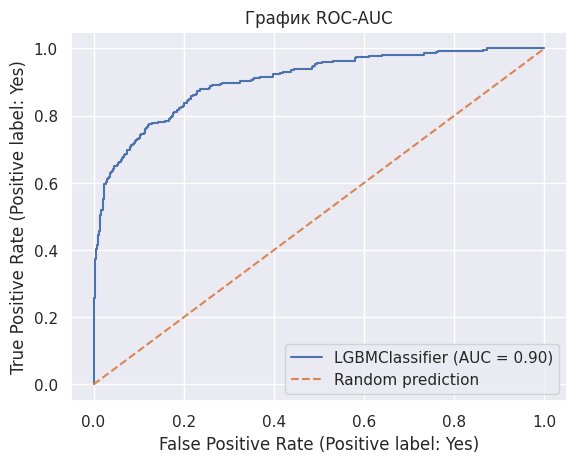

In [ ]:
preds = lgbm_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, preds[:,1])
print('ROC-AUC =', roc_auc.round(2))

RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, label=f'LGBMClassifier (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC")
plt.legend()
plt.show()

График показывает, что ваша модель LGBMClassifier имеет хорошее качество классификации, так как ROC-кривая близка к верхнему левому углу и AUC составляет 0.90. Это означает, что модель имеет высокую чувствительность (True Positive Rate) и специфичность (низкий False Positive Rate) при различных порогах классификации.



Теперь построим матрицу ошибок для более удобной интерпретации результата заказчику.

In [ ]:
y_pred = lgbm_model.predict(X_test)

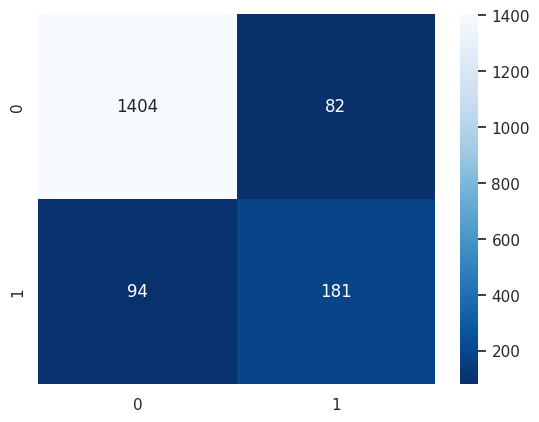

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='Yes')
precision = precision_score(y_test, y_pred, pos_label='Yes')

In [ ]:
print('Accuracy =', accuracy.round(2))
print('Recall =', recall.round(2))
print('Precision =', precision.round(2))

Accuracy = 0.9
Recall = 0.66
Precision = 0.69


## Анализ

**True Negative:**

Модель правильно предсказала класс "No" для 1420 клиентов. Эти клиенты действительно остались с оператором связи, и модель это верно предсказала.

**True Positive:**

Модель правильно предсказала класс "Yes" для 178 клиентов. Эти клиенты действительно ушли, и модель это верно предсказала.

**False Positive (ошибка 1-го рода):**

Модель предсказала класс "Yes" для 66 клиентов, хотя на самом деле эти клиенты остались.

**False Negative (ошибка 2-го рода):**

Модель предсказала класс "No" для 97 клиентов, хотя на самом деле эти клиенты ушли.

In [ ]:
feature_names = lgbm_model.named_steps['preprocessor'].get_feature_names_out()

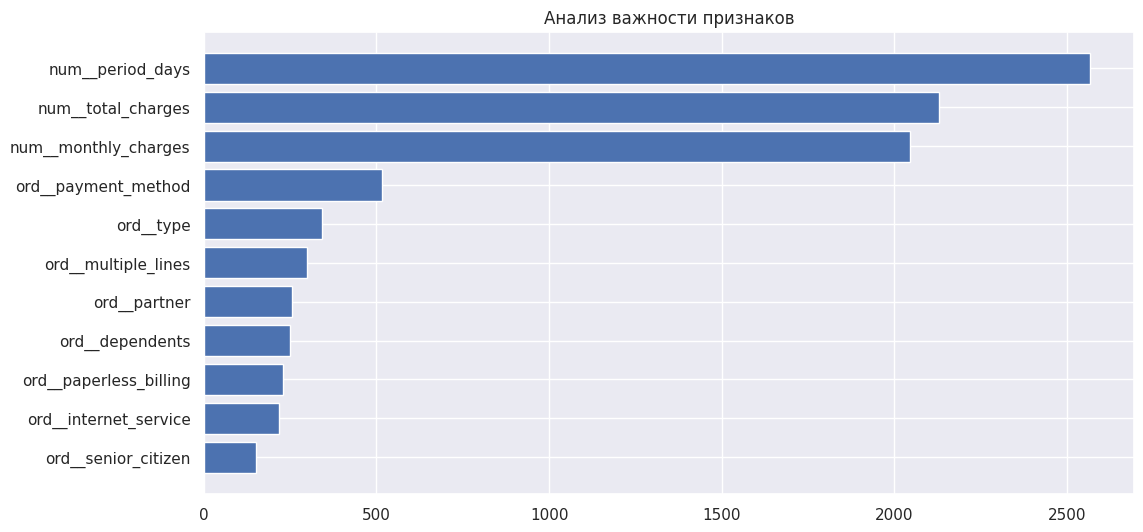

In [ ]:
feature_importance = lgbm_model.named_steps['models'].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title('Анализ важности признаков')
plt.show()

Самыми весомыми признаками оказались все количественные, а вот классы "Out of Service" в `multiple_lines` и `internet_service` имеют самую меньшую значимость.

# Общий вывод

**Данные**

Предоставили 4 датасета:
1. `contract_new.csv` (информация о договоре);
2. `personal_new.csv` (персональные данные клиента);
3. `internet_new.csv` (информация об интернет-услугах);
4. `phone_new.csv` (информация об услугах телефонии)

Столбцы были переименованы, пропущенные значения устранены.

При исследовании целевого признака, оказалось, что в данных присутствует дисбаланс классов, но в овер- и даунсамплинге не было необходимости, так как наша основная метрика ROC-AUC не чувствительна к ней. Также стоит отметить, что все датасеты были объединены, и образовавшиеся пропуски мы устранили новым классом.

При анализе корреляций выяснилось, что одни признаки показывают очень высокую корреляцию (>= 90), другие и вовсе ее не показывают. Они были удалены.

**Поиск лучшей модели:**

Использовал пайплайны для удобства чтения и работы. Категориальные признаки закодировал с помощью OneHotEncoder, количественные с помощью StandardScaler().

Обучил четыре модели: `LogisticRegression`, `RandomForestClassifier` и `LGBMClassifier`, для каждой подобрал гиперпараметры и посчитал метрику `ROC-AUC`

**Лучшая модель:**

Лучшей моделью оказалась LGBMClassifier с гиперпараметрами:
 ```
 class_weight='balanced',
 colsample_bytree=0.6,
 learning_rate=0.05,
 max_depth=20,
 min_child_samples=30,
 n_estimators=300,
 random_state=20052024,
 subsample=0.6,
 verbose=-1
```
**Метрика:**
ROC-AUC на лучшей модели показала 0.90, accuracy = 0.86, recall = 0.71, precision = 0.54.

**Рекомендации:**

Стоит обратить внимание на важность ошибок в контексте задачи:

Ошибка первого рода может привести к ненужным маркетинговым расходам, но это менее критично, чем потеря клиента.

Ошибка второго рода более критична, так как потеря клиента напрямую влияет на доход компании.

Для данной задачи компания «ТелеДом» может стремиться минимизировать ошибки второго рода, так как они имеют более серьезные финансовые последствия. Однако это не означает, что ошибки первого рода можно полностью игнорировать. Необходимо найти баланс между минимизацией обоих типов ошибок.

**Фокус на уходящих клиентах:**

Используйте модель для идентификации клиентов, которые с высокой вероятностью планируют уйти, и предложите им специальные условия, промокоды или скидки. Это поможет снизить отток клиентов.

**Снижение ошибки 2-го рода:**

Для сокращения числа клиентов, которые планировали уйти, но были ошибочно классифицированы как остающиеся (False Negative) можно применить более чувствительные пороги для классификации клиентов.